# Imports

In [1]:
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split

from src.preprocessing import preprocess_data
from src.utils.compute_metrics import compute_and_store_metrics
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.load_data import load_data
from src.utils.save_model import save_model

# Load Data

In [2]:
X, y = preprocess_data(load_data())

# Model

## LightGBM Model

In [3]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
## Model
model = lgb.LGBMClassifier(random_state=42, verbose=-1)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[
    :, 1
]  # Probability estimates for the positive class (default)

In [5]:
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

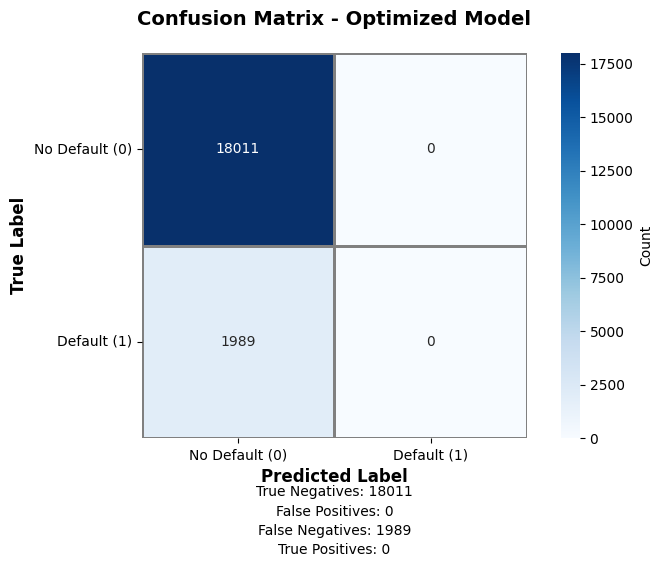


Model Metrics:
Accuracy:  0.9005 (90.05%)
Precision: 0.0000 (0.00%)
Recall:    0.0000 (0.00%)
F1-Score:  0.0000 (0.00%)


In [6]:
plot_confusion_matrix(y_test, y_pred, cmap="Blues")

## Hyperparameter fine-tuning (Optuna)

In [7]:
def objective(trial):
    # Suggest hyperparameters for LightGBM
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5, log=True)
    num_leaves = trial.suggest_int("num_leaves", 20, 150)
    min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    threshold = trial.suggest_float("threshold", 0.3, 0.7)

    # Create the model
    model = lgb.LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        class_weight=class_weight,
        n_jobs=-1,
        verbose=-1,
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[
        :, 1
    ]  # Probability estimates for the positive class (default)
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate F1-score (or any other metric you prefer)
    from sklearn.metrics import f1_score

    score = f1_score(y_test, y_pred)

    return score


# Create and run the study
study = optuna.create_study(direction="maximize")  # Maximize F1-score
study.optimize(objective, n_trials=500, show_progress_bar=True)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"Best F1-Score: {study.best_value:.4f}")
print("\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-15 21:50:14,481] A new study created in memory with name: no-name-2ecdcf68-b3be-4611-a421-34502c4ee05e


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-10-15 21:50:16,455] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 370, 'max_depth': 5, 'learning_rate': 0.05749670373779263, 'num_leaves': 51, 'min_child_samples': 64, 'subsample': 0.689060819991896, 'colsample_bytree': 0.9343492179450521, 'class_weight': None, 'threshold': 0.6195570552642986}. Best is trial 0 with value: 0.0.
[I 2025-10-15 21:50:17,655] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 231, 'max_depth': 41, 'learning_rate': 0.35952268665236453, 'num_leaves': 27, 'min_child_samples': 56, 'subsample': 0.1242500939781049, 'colsample_bytree': 0.7899872173989884, 'class_weight': None, 'threshold': 0.6299109989721283}. Best is trial 0 with value: 0.0.
[I 2025-10-15 21:50:19,518] Trial 2 finished with value: 0.04331087584215592 and parameters: {'n_estimators': 145, 'max_depth': 48, 'learning_rate': 0.05074262703777879, 'num_leaves': 56, 'min_child_samples': 42, 'subsample': 0.9460041874573591, 'colsample_bytree': 0.5245979957730182

In [8]:
# Train the final model with best parameters
best_params = study.best_params.copy()
threshold = best_params.pop("threshold")

model = lgb.LGBMClassifier(**best_params, random_state=42, verbose=-1)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)

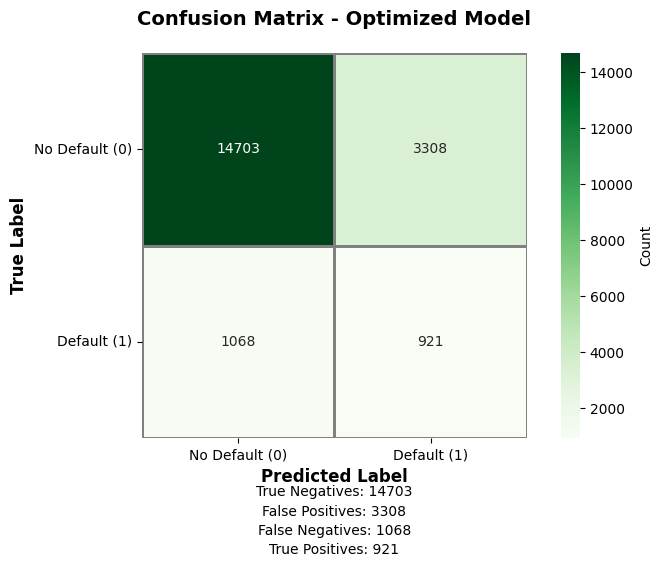


Model Metrics:
Accuracy:  0.7812 (78.12%)
Precision: 0.2178 (21.78%)
Recall:    0.4630 (46.30%)
F1-Score:  0.2962 (29.62%)


In [9]:
plot_confusion_matrix(y_test, y_pred, cmap="Greens")

In [10]:
compute_and_store_metrics(y_test, y_pred, model_name="LightGBM")

In [11]:
# Final training on the entire dataset
model = lgb.LGBMClassifier(**best_params, verbose=-1)
model.fit(X, y)
save_model(model, model_name="LightGBM")